# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit



In [2]:
future = pd.read_excel("data/futures.xlsx",header=0)
spot25 = pd.read_excel("data/spot_price_25.xlsx",header = 0 )
spot24 = pd.read_excel("data/spot_price_24.xlsx",header = 0 )

In [3]:
future["date"]= pd.to_datetime(future["date"])
future.ffill(inplace=True)
future = future[future['date'] >= "2024-01-01"]

future.head()

,date,TRFRBYc1,TRFRBMc1,TRFRBFVMG6,TRFRBFVMH6,TRFRBFVMJ6,TRFRBFVMK6,TRFRBFVMM6,TRFRBFVMN6,TRFRBFVMQ6,...,TRFRBFVMH7,TRFRBFVMJ7,TRFRBFVMK7,TRFRBFVMM7,TRFRBFVMN7,TRFRBFVMQ7,TRFRBFVMU7,TRFRBFVMV7,TRFRBFVMX7,TRFRBFVMZ7
0,2026-01-09,49.45,76.85,76.69,57.38,40.31,20.86,27.87,37.38,39.73,...,65.94,33.69,16.92,23.38,31.89,33.94,36.19,58.51,68.85,68.04
1,2026-01-08,48.50,74.65,74.65,56.40,39.33,19.65,27.18,36.04,38.70,...,65.12,33.69,16.81,22.19,31.37,33.26,35.46,58.20,68.49,67.68
2,2026-01-07,48.75,73.50,73.49,56.79,39.48,19.60,25.88,35.54,37.95,...,65.63,34.57,16.24,22.51,31.18,33.04,35.23,57.94,68.18,67.38
3,2026-01-06,48.70,72.70,72.51,56.16,39.12,18.27,25.35,34.55,36.85,...,65.10,34.90,16.09,22.49,31.33,33.14,35.34,58.11,68.38,67.59
4,2026-01-05,48.80,70.00,70.21,54.91,38.85,17.80,24.90,34.05,36.25,...,64.98,35.02,16.86,22.90,31.13,32.86,35.02,58.22,68.52,67.69


In [4]:
# Lecture et traitement des fichiers Spot22, Spot23, Spot24, Spot25
spot_files = ["data/spot_price_22.xlsx", "data/spot_price_23.xlsx", "data/spot_price_24.xlsx", "data/spot_price_25.xlsx"]
spot_data = []

for file in spot_files:
    spot = pd.read_excel(file)
    spot['Date'] = spot['Date'].str.split(' - ').str[0]  # Prendre uniquement le début de la plage
    spot['Date'] = pd.to_datetime(spot['Date'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
    spot = spot.dropna(subset=['Date'])  # Suppression des lignes avec des dates invalides
    daily = spot.groupby(spot['Date'].dt.date)['Day-ahead'].mean().reset_index()
    daily.rename(columns={'Date': 'date', 'Day-ahead': 'price'}, inplace=True)
    spot_data.append(daily)

# Fusion des bases de données
spot_merged = pd.concat(spot_data).groupby('date', as_index=False)['price'].mean()

# Affichage des premières lignes du résultat
spot_merged.head()


,date,price
0,2022-01-01,86.260833
1,2022-01-02,47.407500
2,2022-01-03,97.810000
3,2022-01-04,157.446667
4,2022-01-05,189.494167


In [5]:
spot_merged.loc[spot_merged['price'] <= 0, 'price'] = np.nan
spot_merged['price'] = spot_merged['price'].ffill()

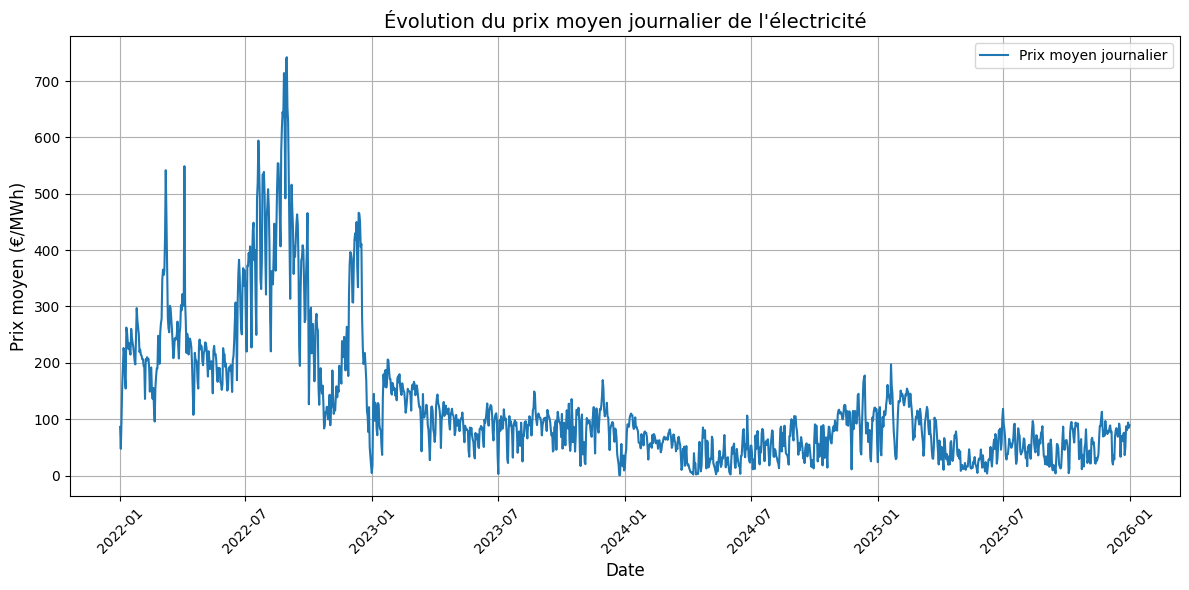

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(spot_merged['date'], spot_merged['price'], linestyle='-', label='Prix moyen journalier')
plt.title("Évolution du prix moyen journalier de l'électricité", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Convertir la colonne 'date' en type datetime64 pour éviter les incompatibilités de types
spot_merged['date'] = pd.to_datetime(spot_merged['date'])

# Filtrer les données pour conserver uniquement les dates à partir du 1er janvier 2023
spot_merged = spot_merged[spot_merged['date'] >= pd.Timestamp('2023-01-01')]


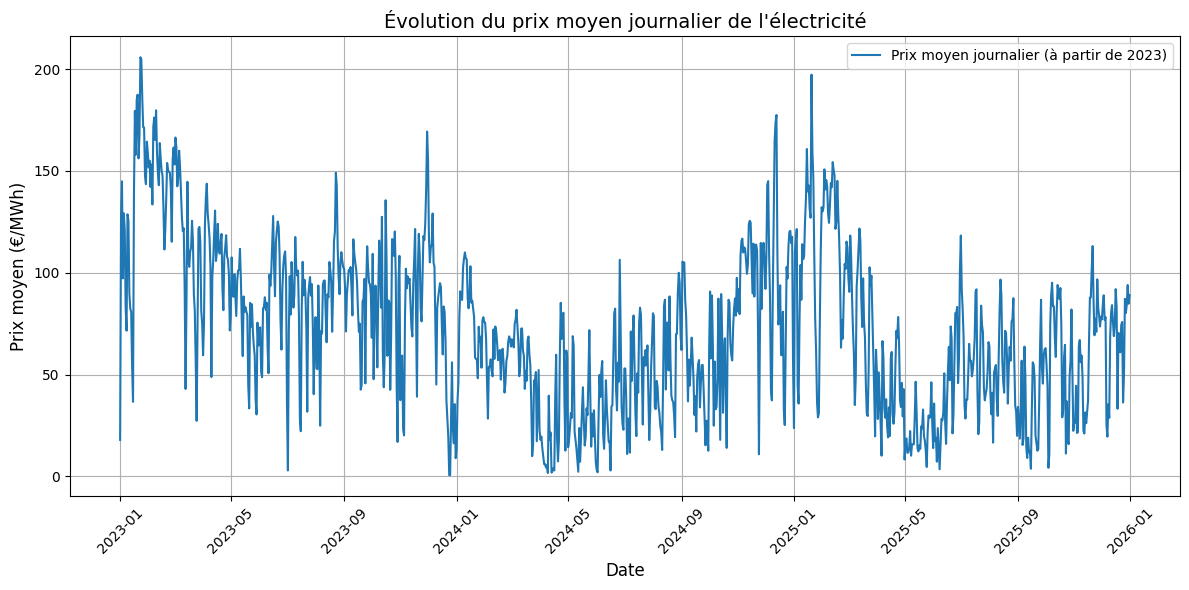

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(spot_merged['date'], spot_merged['price'], linestyle='-', label='Prix moyen journalier (à partir de 2023)')
plt.title("Évolution du prix moyen journalier de l'électricité", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Ajouter des colonnes "jour", "mois", "semaine" et "saison"
spot_merged['jour'] = spot_merged['date'].dt.day_name()
spot_merged['mois'] = spot_merged['date'].dt.month_name()
spot_merged['semaine'] = spot_merged['date'].dt.isocalendar().week
spot_merged['saison'] = spot_merged['date'].dt.month % 12 // 3 + 1
spot_merged['saison'] = spot_merged['saison'].map({1: 'Hiver', 2: 'Printemps', 3: 'Été', 4: 'Automne'})


Statistiques descriptives par jour de la semaine:
           count       mean        std        min        25%        50%  \
jour                                                                      
Friday     156.0  77.547948  37.992099   6.008333  54.388229  78.793073   
Monday     157.0  76.072197  40.311244   0.600000  46.892917  73.590417   
Saturday   156.0  61.733245  36.331542   1.858750  31.779896  56.751875   
Sunday     157.0  51.744751  37.181654   0.597500  19.778750  45.536667   
Thursday   156.0  79.254841  39.663877   7.231667  52.840833  80.168281   
Tuesday    157.0  79.423432  40.004813   1.659167  49.847917  77.178333   
Wednesday  157.0  80.163034  38.417830  13.785417  51.245417  82.275833   

                  75%         max  
jour                               
Friday      99.009062  187.445833  
Monday     101.276667  205.830000  
Saturday    86.250208  156.182500  
Sunday      74.291250  167.334167  
Thursday   105.515104  185.080833  
Tuesday    105.366250 

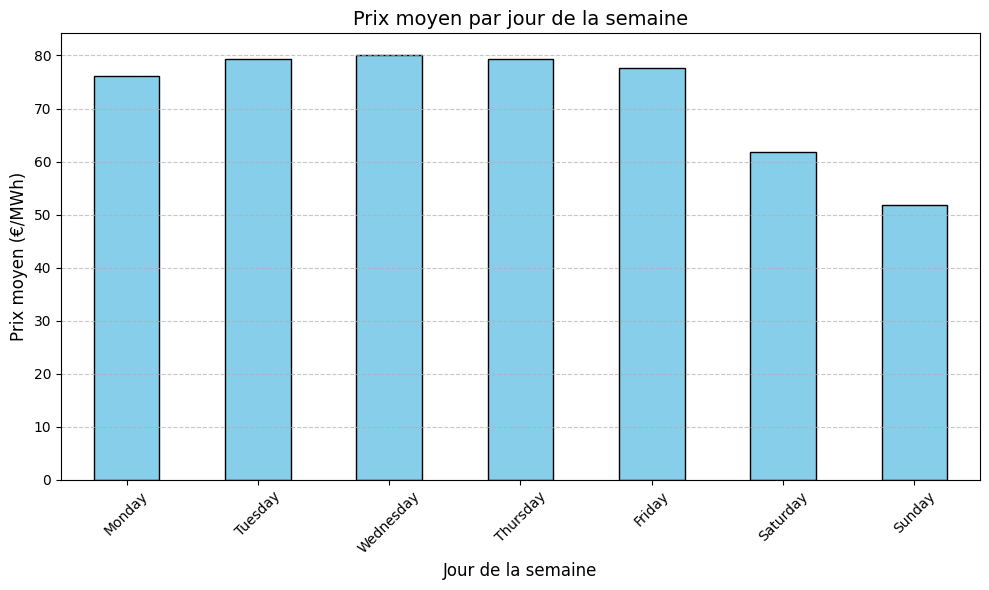

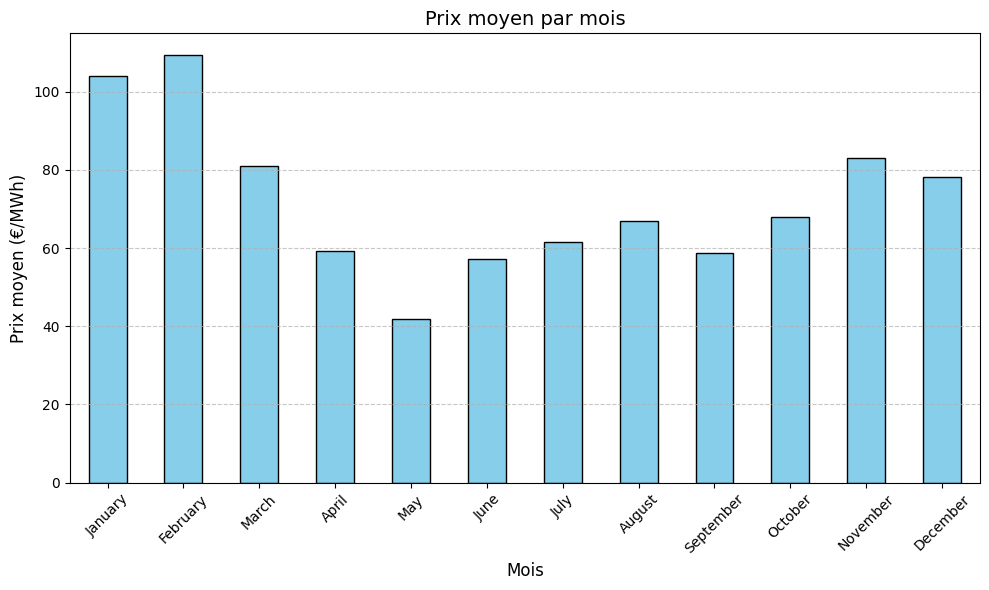

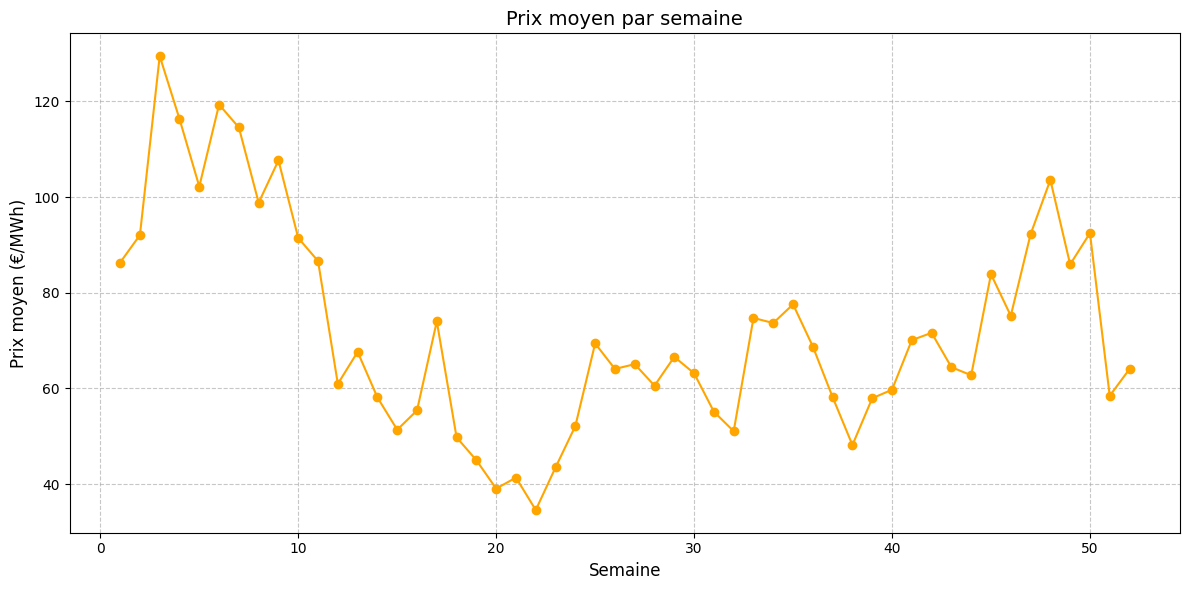

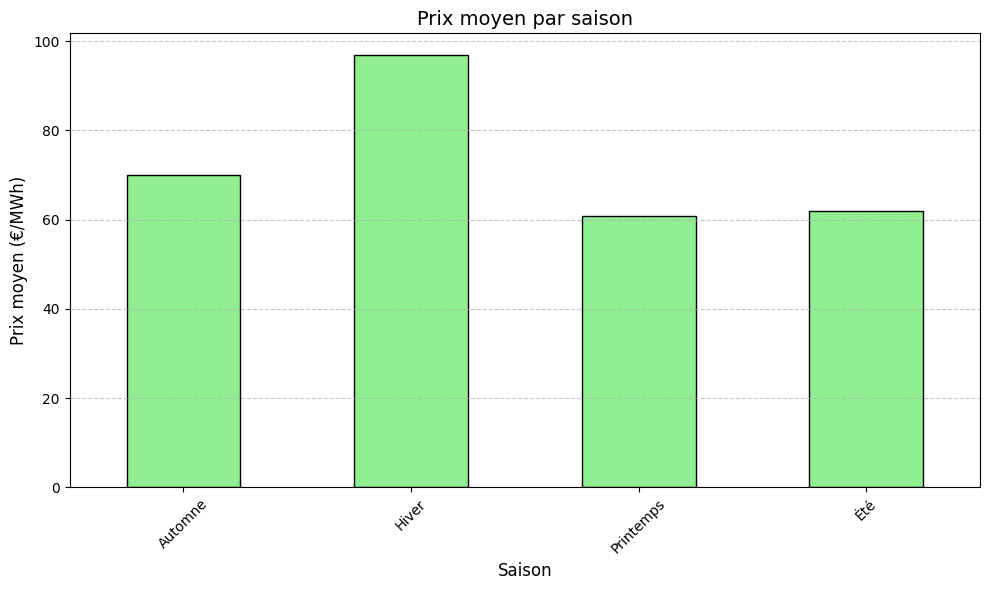

<Figure size 1200x800 with 0 Axes>

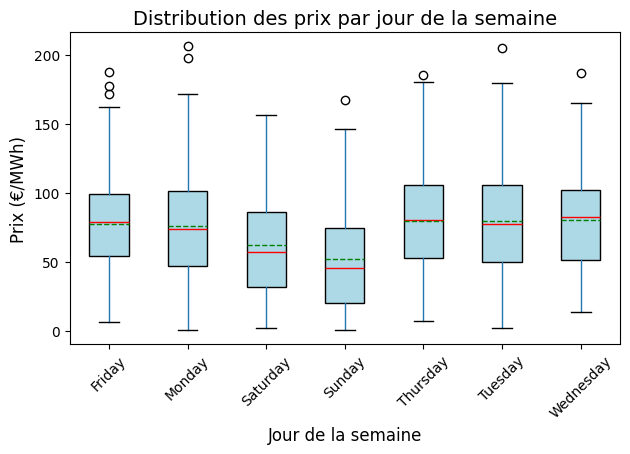

<Figure size 1200x800 with 0 Axes>

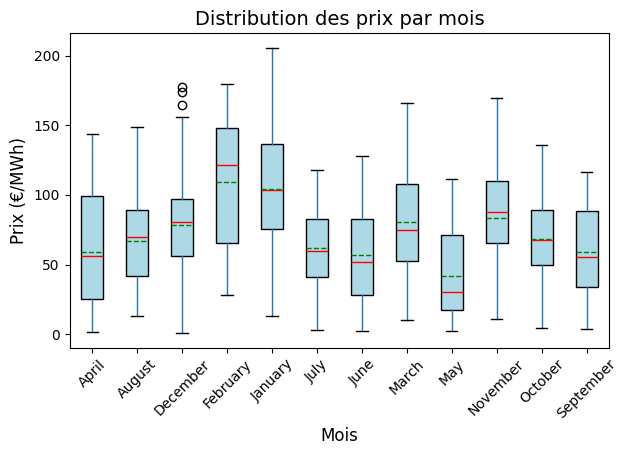

<Figure size 1200x800 with 0 Axes>

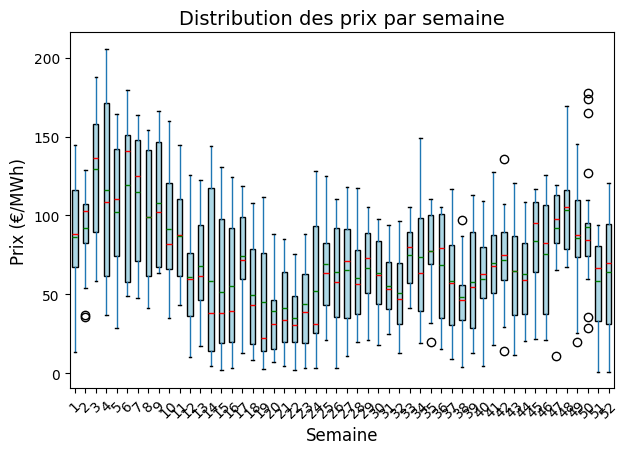

<Figure size 1200x800 with 0 Axes>

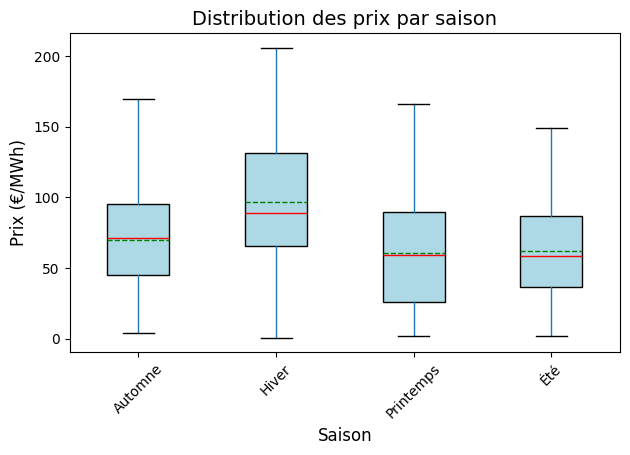

In [10]:
# Statistiques descriptives pour mesurer la saisonnalité par jour, mois, semaine et saison
stats_by_day = spot_merged.groupby('jour')['price'].describe()
stats_by_month = spot_merged.groupby('mois')['price'].describe()
stats_by_week = spot_merged.groupby('semaine')['price'].describe()
stats_by_season = spot_merged.groupby('saison')['price'].describe()

print("Statistiques descriptives par jour de la semaine:")
print(stats_by_day)
print("\nStatistiques descriptives par mois:")
print(stats_by_month)
print("\nStatistiques descriptives par semaine:")
print(stats_by_week)
print("\nStatistiques descriptives par saison:")
print(stats_by_season)

# Graphique de la moyenne des prix par jour de la semaine
plt.figure(figsize=(10, 6))
spot_merged.groupby('jour')['price'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Prix moyen par jour de la semaine", fontsize=14)
plt.xlabel("Jour de la semaine", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par mois
plt.figure(figsize=(10, 6))
spot_merged.groupby('mois')['price'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'
]).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Prix moyen par mois", fontsize=14)
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par semaine
plt.figure(figsize=(12, 6))
spot_merged.groupby('semaine')['price'].mean().plot(color='orange', linestyle='-', marker='o')
plt.title("Prix moyen par semaine", fontsize=14)
plt.xlabel("Semaine", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par saison
plt.figure(figsize=(10, 6))
spot_merged.groupby('saison')['price'].mean().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Prix moyen par saison", fontsize=14)
plt.xlabel("Saison", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par jour de la semaine
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='jour', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par jour de la semaine", fontsize=14)
plt.suptitle("")  # Supprimer le titre par défaut de boxplot
plt.xlabel("Jour de la semaine", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par mois
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='mois', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par mois", fontsize=14)
plt.suptitle("")
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par semaine
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='semaine', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par semaine", fontsize=14)
plt.suptitle("")
plt.xlabel("Semaine", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par saison
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='saison', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par saison", fontsize=14)
plt.suptitle("")
plt.xlabel("Saison", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# 1. Prépare les données (Log-Prix & Mois continu pour lissage)
spot_merged['log_price'] = np.log(spot_merged['price'])
# Crée un axe temporel lisse (ex: 15 Jan = 1.48) pour éviter les escaliers
spot_merged['t_smooth'] = spot_merged['date'].dt.month + (spot_merged['date'].dt.day - 1) / spot_merged['date'].dt.days_in_month

# 2. Agrégation Mensuelle (Calibration sur 12 points seulement)
monthly = spot_merged.groupby(spot_merged['date'].dt.month)['log_price'].mean()
X_fit, Y_fit = monthly.index.values, monthly.values

# 3. Fonction Fourier dynamique
def fourier(x, *a):
    res = a[0]
    for i in range((len(a)-1)//2):
        k = 2 * np.pi * (i+1) * x / 12
        res += a[2*i+1] * np.sin(k) + a[2*i+2] * np.cos(k)
    return res

# 4. Calibration (Trouve le meilleur ordre entre 1 et 3)
best = (float('inf'), None)
for order in range(1, 6):
    try:
        # p0 : Moyenne + des petits coeffs
        popt, _ = curve_fit(fourier, X_fit, Y_fit, p0=[np.mean(Y_fit)] + [0.1]*(2*order))
        resid = np.sum((Y_fit - fourier(X_fit, *popt))**2)
        if resid < best[0]: best = (resid, popt)
    except: pass

# 5. Application & Calcul de Xt
# On applique les params mensuels sur l'axe temporel lisse journalier
spot_merged['seasonality'] = fourier(spot_merged['t_smooth'], *best[1])
spot_merged['Xt'] = spot_merged['log_price'] - spot_merged['seasonality']

print(f"Saisonnalité calibrée (Ordre {(len(best[1])-1)//2})")

Saisonnalité calibrée (Ordre 5)


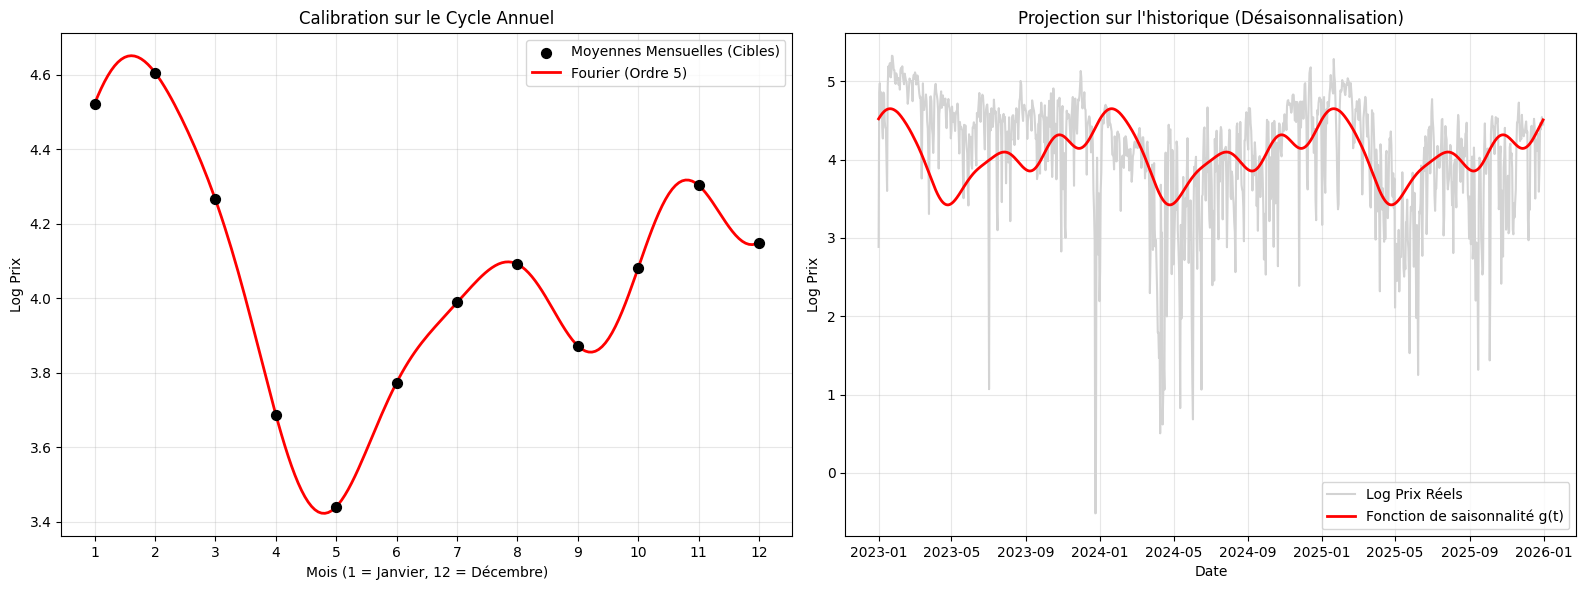

In [27]:
plt.figure(figsize=(16, 6))

# Graphique 1 : Calibration sur le cycle annuel
plt.subplot(1, 2, 1)
# Les points mensuels (Moyennes)
plt.scatter(X_fit, Y_fit, color='black', s=50, label='Moyennes Mensuelles (Cibles)', zorder=3)

# La courbe lissée (Fourier)
x_smooth_plot = np.linspace(1, 12, 200)
y_smooth_plot = fourier(x_smooth_plot, *best[1])
plt.plot(x_smooth_plot, y_smooth_plot, color='red', linewidth=2, label=f'Fourier (Ordre {(len(best[1])-1)//2})')

plt.title("Calibration sur le Cycle Annuel")
plt.xlabel("Mois (1 = Janvier, 12 = Décembre)")
plt.ylabel("Log Prix")
plt.xticks(np.arange(1, 13)) # Force l'affichage de 1 à 12
plt.grid(True, alpha=0.3)
plt.legend()

# Graphique 2 : Projection sur l'historique
plt.subplot(1, 2, 2)
# Les log-prix réels
plt.plot(spot_merged['date'], spot_merged['log_price'], color='lightgray', label='Log Prix Réels')

# Fonction de saisonnalité lissée
plt.plot(spot_merged['date'], spot_merged['seasonality'], color='red', linewidth=2, label='Fonction de saisonnalité g(t)')

plt.title("Projection sur l'historique (Désaisonnalisation)")
plt.xlabel("Date")
plt.ylabel("Log Prix")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
import numpy as np
from sklearn.linear_model import LinearRegression

Xt = spot_merged['Xt']
Y = Xt.diff().dropna()
X_lag = Xt.shift(1).dropna()

common_index = Y.index.intersection(X_lag.index)
Y = Y.loc[common_index].values.reshape(-1, 1)
X = X_lag.loc[common_index].values.reshape(-1, 1)

# Régression Linéaire
reg = LinearRegression(fit_intercept=False)
reg.fit(X, Y)

# La pente est égale à : - alpha * dt
slope = reg.coef_[0][0]
dt = 1 / 365.25 # Pas de temps journalier en années

alpha = -slope

print(f"Pente de la régression : {slope:.6f}")
print(f"Mean Reversion Rate journalier (Alpha*dt) : {alpha:.4f}")
print(f"Mean Reversion Rate annuel (Alpha) : {alpha/dt:.4f}")
print(f"Demi-vie : {-np.log(0.5)/alpha:.1f} jours environ")
print(f"99% du choc : {-np.log(0.01)/alpha:.1f} jours environ")

Pente de la régression : -0.291965
Mean Reversion Rate journalier (Alpha*dt) : 0.2920
Mean Reversion Rate annuel (Alpha) : 106.6403
Demi-vie : 2.4 jours environ
99% du choc : 15.8 jours environ


Itérations 9
Fréquence des sauts (J) : 18.00 sauts/an
Taille moyenne saut (Mu_J)   : 0.4213
Volatilité saut (Sigma_J)    : 1.8001


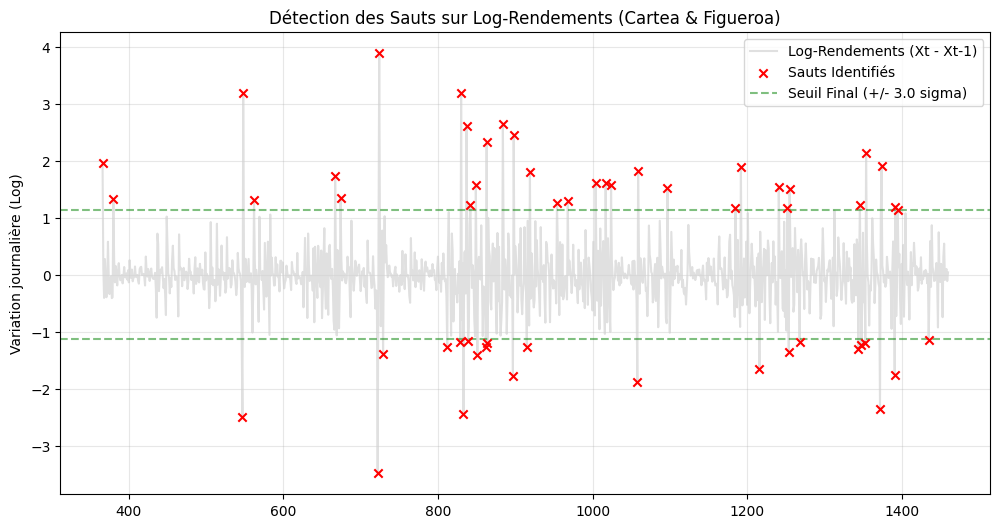

In [18]:
returns = spot_merged['Xt'].diff().dropna()
current_series = returns.copy()
jumps_found = []
jump_indices = []

# Seuil de détection des sauts (regle des 3-sigmas)
SIGMA_THRESHOLD = 3.0

iteration = 0
while True:
    iteration += 1
    std_dev = current_series.std()
    is_jump = np.abs(current_series) > SIGMA_THRESHOLD * std_dev
    if not is_jump.any():
        break

    new_jumps = current_series[is_jump]
    jumps_found.extend(new_jumps.values)
    jump_indices.extend(new_jumps.index)

    current_series = current_series[~is_jump]
print(f"Itérations {iteration}")

# Paramètres des Sauts (Jumps)
jumps_array = np.array(jumps_found)

# J : Nombre de sauts par an
years = (spot_merged['date'].max() - spot_merged['date'].min()).days / 365
lambda_jump = len(jumps_array) / years

# Mu et Sigma du saut
mu_jump = jumps_array.mean()
sigma_jump = jumps_array.std()

print(f"Fréquence des sauts (J) : {lambda_jump:.2f} sauts/an")
print(f"Taille moyenne saut (Mu_J)   : {mu_jump:.4f}")
print(f"Volatilité saut (Sigma_J)    : {sigma_jump:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns, color='lightgray', label='Log-Rendements (Xt - Xt-1)', alpha=0.7)
# Sauts détectés
plt.scatter(jump_indices, jumps_found, color='red', marker='x', label='Sauts Identifiés', zorder=5)
# Seuil final
limit = SIGMA_THRESHOLD * current_series.std()
plt.axhline(limit, color='green', linestyle='--', alpha=0.5, label=f'Seuil Final (+/- {SIGMA_THRESHOLD} sigma)')
plt.axhline(-limit, color='green', linestyle='--', alpha=0.5)

plt.title("Détection des Sauts sur Log-Rendements (Cartea & Figueroa)")
plt.ylabel("Variation journalière (Log)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()